In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.model_selection import train_test_split

%matplotlib inline

# Data

Gathering and preparation of the data to be inputed into the model.

The countries were selected in the EDA file, populations were taken from https://worldpopulationreview.com/countries.

In [2]:
# Spain, UK, Italy, Germany...
# cc_dict = {
#     'ARG': 'Argentina', 'AUS': 'Australia',  
#     'CHN': 'China',     'CZE': 'Czechia',    
#     'EGY': 'Egypt',     'FIN': 'Finland',
#     'HND': 'Honduras',  'IND': 'India',
#     'JPN': 'Japan',     'NOR': 'Norway',
#     'RUS': 'Russia',    'SWE': 'Sweden',
#     'THA': 'Thailand',  'USA': 'US'
# }

cc_dict = {
    'BEL': 'Belgium',      'CMR': 'Cameroon',    'DOM': 'Dominican Republic',
    'EGY': 'Egypt',        'IRQ': 'Iraq',        'JOR': 'Jordan',
    'MLI': 'Mali',         'MWI': 'Malawi',      'NLD': 'Netherlands',
    'POL': 'Poland',       'SSD': 'South Sudan', 'TUN': 'Tunisia',
    'ZAF': 'South Africa', 'ZMB': 'Zambia',      'ZWE': 'Zimbabwe'
}

# pop_dict = { # 2020 population
#     'ARG': 45195774,   'AUS': 25499884, 
#     'CHN': 1439323776, 'CZE': 10708981,   
#     'EGY': 102334404,  'FIN': 5540720,  
#     'HND': 9904607,    'IND': 1380004385, 
#     'JPN': 126476461,  'NOR': 5421241,  
#     'RUS': 145934462,  'SWE': 10099265,
#     'THA': 69799978,   'USA': 331002651
# }

pop_dict = {
    'BEL': 11589623,  'CMR': 26545863, 'DOM': 10847910,
    'EGY': 102334404, 'IRQ': 40222493, 'JOR': 10203134,
    'MLI': 20250833,  'MWI': 19129952, 'NLD': 17134872,
    'POL': 37846611,  'SSD': 11193725, 'TUN': 11818619,
    'ZAF': 59308690,  'ZMB': 18383955, 'ZWE': 14862924
}

# pd.read_html('https://worldpopulationreview.com/countries', header=0, index_col=1)[0].reindex(cc_dict.values())

## Virus

Virus propagation data is obtained from the CSSE at Johns Hopkins University.

In [3]:
url_cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recov = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [4]:
jhu_cases = pd.read_csv(url_cases)
jhu_cases.shape

(279, 554)

In [5]:
jhu_death = pd.read_csv(url_death)
jhu_death.shape

(279, 554)

In [6]:
jhu_recov = pd.read_csv(url_recov)
jhu_recov.shape

(264, 554)

Australia, Canada and China are reported at the province/state level. Dependencies of the Netherlands, the UK, France and Denmark are listed under the province/state level.

This is shown for the `cases` data set, but it happens in the three of them.

In [7]:
jhu_cases[jhu_cases['Country/Region'] == 'Australia']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,6/15/21,6/16/21,6/17/21,6/18/21,6/19/21,6/20/21,6/21/21,6/22/21,6/23/21,6/24/21,6/25/21,6/26/21,6/27/21,6/28/21,6/29/21,6/30/21,7/1/21,7/2/21,7/3/21,7/4/21,7/5/21,7/6/21,7/7/21,7/8/21,7/9/21,7/10/21,7/11/21,7/12/21,7/13/21,7/14/21,7/15/21,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21,7/21/21,7/22/21,7/23/21,7/24/21
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,5626,5629,5631,5637,5642,5649,5655,5666,5684,5695,5725,5756,5778,5798,5826,5854,5886,5926,5942,5979,5997,6025,6064,6109,6161,6243,6359,6452,6551,6618,6716,6833,6942,7042,7121,7233,7357,7498,7492,7792
10,Northern Territory,Australia,-12.4634,130.8456,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,175,175,175,176,176,176,176,177,177,177,178,181,181,184,184,185,185,185,185,185,185,185,185,186,188,188,188,189,189,189,190,191,191,191,191,191,191,191,191,192
11,Queensland,Australia,-27.4698,153.0251,0,0,0,0,0,0,0,1,3,2,3,2,2,3,3,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,...,1655,1661,1664,1664,1665,1670,1673,1674,1678,1679,1680,1683,1686,1690,1696,1700,1705,1714,1715,1723,1728,1729,1732,1732,1737,1738,1739,1742,1747,1752,1753,1754,1755,1757,1761,1761,1761,1764,1763,1770
12,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,776,780,781,784,785,788,788,788,788,792,789,791,794,796,801,807,807,809,810,813,813,813,813,814,816,818,819,821,821,823,825,831,831,832,838,840,846,850,851,855
13,Tasmania,Australia,-42.8821,147.3272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234
14,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,1,1,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,20676,20678,20680,20683,20685,20694,20696,20697,20699,20702,20706,20708,20708,20710,20712,20712,20715,20713,20714,20716,20718,20718,20718,20719,20722,20722,20722,20725,20727,20737,20748,20767,20785,20799,20813,20837,20865,20879,20891,20903
15,Western Australia,Australia,-31.9505,115.8605,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1020,1020,1020,1020,1020,1020,1020,1020,1020,1021,1021,1022,1023,1024,1025,1027,1028,1029,1029,1030,1032,1033,1033,1033,1033,1033,1036,1036,1036,1036,1036,1037,1037,1037,1038,1046,1048,1048,1048,1048


In [8]:
jhu_cases[jhu_cases['Country/Region'] == 'Netherlands']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,6/15/21,6/16/21,6/17/21,6/18/21,6/19/21,6/20/21,6/21/21,6/22/21,6/23/21,6/24/21,6/25/21,6/26/21,6/27/21,6/28/21,6/29/21,6/30/21,7/1/21,7/2/21,7/3/21,7/4/21,7/5/21,7/6/21,7/7/21,7/8/21,7/9/21,7/10/21,7/11/21,7/12/21,7/13/21,7/14/21,7/15/21,7/16/21,7/17/21,7/18/21,7/19/21,7/20/21,7/21/21,7/22/21,7/23/21,7/24/21
193,Aruba,Netherlands,12.5211,-69.9683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11084,11089,11099,11103,11106,11108,11112,11116,11118,11125,11126,11131,11131,11132,11135,11138,11140,11144,11144,11144,11144,11144,11144,11144,11169,11169,11169,11169,11180,11186,11199,11199,11223,11235,11244,11257,11272,11293,11325,11354
194,"Bonaire, Sint Eustatius and Saba",Netherlands,12.1784,-68.2385,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1623,1627,1629,1629,1630,1632,1633,1634,1634,1635,1636,1639,1640,1640,1646,1649,1650,1651,1651,1651,1652,1652,1652,1654,1656,1658,1659,1660,1661,1661,1661,1664,1668,1672,1672,1683,1683,1690,1691,1692
195,Curacao,Netherlands,12.1696,-68.9900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,12296,12304,12308,12314,12317,12318,12319,12321,12322,12327,12327,12330,12330,12332,12339,12342,12343,12345,12349,12349,12349,12350,12354,12364,12371,12380,12389,12395,12418,12453,12537,12605,12699,12775,12804,12883,12962,13038,13135,13217
196,Sint Maarten,Netherlands,18.0425,-63.0548,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2543,2554,2561,2564,2570,2570,2575,2582,2585,2594,2601,2601,2601,2613,2614,2618,2618,2618,2620,2620,2627,2630,2632,2633,2633,2638,2638,2641,2650,2656,2659,2659,2664,2664,2677,2687,2695,2698,2698,2707
197,NaN,Netherlands,52.1326,5.2913,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1674628,1675644,1676708,1677596,1678282,1678983,1679542,1680228,1680880,1681580,1682221,1682773,1683271,1683828,1684366,1685000,1685825,1686766,1687891,1689106,1690625,1692834,1696480,1701911,1708837,1719120,1728438,1736879,1744700,1755126,1766102,1777399,1788435,1798570,1807444,1814143,1821040,1827273,1833668,1838937


Canada does not have recovery data available at province-level.

In [9]:
jhu_cases['Country/Region'].value_counts().head(9)

China             34
Canada            16
France            12
United Kingdom    12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Peru               1
Name: Country/Region, dtype: int64

In [10]:
jhu_death['Country/Region'].value_counts().head(9)

China             34
Canada            16
France            12
United Kingdom    12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Peru               1
Name: Country/Region, dtype: int64

In [11]:
jhu_recov['Country/Region'].value_counts().head(9)

China             34
France            12
United Kingdom    12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Cuba               1
Jordan             1
Name: Country/Region, dtype: int64

Remove global registries from countries with subregional registies and the sum up these subregional cases.

In [12]:
sel_reg = ['Netherlands', 'United Kingdom', 'France', 'Denmark']

def remove_global_registry(jhu_df):
  'Remove global country records when local ones exist.'
  a = jhu_df['Country/Region'].isin(sel_reg)
  b = jhu_df['Province/State'].isna()
  cond = pd.DataFrame([a, b]).all()
  idx = jhu_df[cond].index
  jhu_df.drop(idx, axis=0, inplace=True)

# remove global Netherlands, UK, France and Denmark
remove_global_registry(jhu_cases)
remove_global_registry(jhu_death)
remove_global_registry(jhu_recov)
# drop subregion, latitude and longitude columns
jhu_cases.drop(jhu_cases.columns[[0, 2, 3]], axis=1, inplace=True)
jhu_death.drop(jhu_death.columns[[0, 2, 3]], axis=1, inplace=True)
jhu_recov.drop(jhu_recov.columns[[0, 2, 3]], axis=1, inplace=True)

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (275, 551)
deaths shape: (275, 551)
recoveries shape: (260, 551)


In [13]:
# reshape dfs
jhu_cases = jhu_cases.groupby('Country/Region').sum()
jhu_cases = jhu_cases.T # transpose columns / rows
jhu_cases.index = pd.to_datetime(jhu_cases.index)
jhu_death = jhu_death.groupby('Country/Region').sum()
jhu_death = jhu_death.T # transpose columns / rows
jhu_death.index = pd.to_datetime(jhu_death.index)
jhu_recov = jhu_recov.groupby('Country/Region').sum()
jhu_recov = jhu_recov.T # transpose columns / rows
jhu_recov.index = pd.to_datetime(jhu_recov.index)

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (550, 195)
deaths shape: (550, 195)
recoveries shape: (550, 195)


Create separate dataframes containing data on countries of interest only. Use them to compute further variables needed for the model.

In [14]:
cum_cases = jhu_cases[cc_dict.values()]
cum_cases

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,1108675,81467,337975,283813,1510517,762420,14522,44684,28510,2881594,10917,554911,2311232,187602,88415
2021-07-21,1108675,81467,338291,283862,1518837,762706,14524,45465,28612,2881718,10917,555997,2327472,188573,91120
2021-07-22,1112161,81871,338902,283906,1526943,763106,14527,46417,28719,2881840,10917,558306,2342330,189731,93421
2021-07-23,1112161,81871,338902,283906,1535848,763437,14532,47265,28849,2881948,10917,558306,2356049,190615,95686


In [15]:
cum_deaths = jhu_death[cc_dict.values()]
cum_deaths

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,25213,1330,3928,16457,17951,9916,530,1363,286,75219,117,17821,67676,3138,2747
2021-07-21,25213,1330,3929,16465,18020,9922,530,1389,286,75222,117,17913,68192,3162,2809
2021-07-22,25217,1332,3931,16470,18101,9929,530,1410,286,75231,117,18052,68625,3196,2870
2021-07-23,25217,1332,3931,16470,18167,9933,530,1439,286,75235,117,18052,69075,3221,2961


In [16]:
cum_recoveries = jhu_recov[cc_dict.values()]
cum_recoveries

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,0,35261,280645,225068,1372158,744365,12376,35203,27563,2652994,10514,443979,2085119,174728,58155
2021-07-21,0,35261,282841,225869,1379074,745005,12626,35432,27585,2653025,10514,449036,2098818,175429,59627
2021-07-22,0,35261,287607,226535,1386331,745551,12868,35792,27625,2653088,10514,453865,2109820,177419,61723
2021-07-23,0,35261,287607,226535,1394536,746015,13119,36019,27679,2653172,10514,453865,2133196,179171,62986


In [17]:
print('Total number of missing values in')
print(' - cases:', cum_cases.isna().sum().sum())
print(' - deaths:', cum_deaths.isna().sum().sum())
print(' - recoveries:', cum_recoveries.isna().sum().sum())

Total number of missing values in
 - cases: 0
 - deaths: 0
 - recoveries: 0


In [18]:
R = cum_deaths + cum_recoveries
R

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,25213,36591,284573,241525,1390109,754281,12906,36566,27849,2728213,10631,461800,2152795,177866,60902
2021-07-21,25213,36591,286770,242334,1397094,754927,13156,36821,27871,2728247,10631,466949,2167010,178591,62436
2021-07-22,25217,36593,291538,243005,1404432,755480,13398,37202,27911,2728319,10631,471917,2178445,180615,64593
2021-07-23,25217,36593,291538,243005,1412703,755948,13649,37458,27965,2728407,10631,471917,2202271,182392,65947


In [19]:
I = cum_cases - R
I

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,1083462,44876,53402,42288,120408,8139,1616,8118,661,153381,286,93111,158437,9736,27513
2021-07-21,1083462,44876,51521,41528,121743,7779,1368,8644,741,153471,286,89048,160462,9982,28684
2021-07-22,1086944,45278,47364,40901,122511,7626,1129,9215,808,153521,286,86389,163885,9116,28828
2021-07-23,1086944,45278,47364,40901,123145,7489,883,9807,884,153541,286,86389,153778,8223,29739


In [20]:
S = pop_dict.values() - cum_cases
S

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-22,11589623,26545863,10847910,102334404,40222493,10203134,20250833,19129952,17134872,37846611,11193725,11818619,59308690,18383955,14862924
2020-01-23,11589623,26545863,10847910,102334404,40222493,10203134,20250833,19129952,17134872,37846611,11193725,11818619,59308690,18383955,14862924
2020-01-24,11589623,26545863,10847910,102334404,40222493,10203134,20250833,19129952,17134872,37846611,11193725,11818619,59308690,18383955,14862924
2020-01-25,11589623,26545863,10847910,102334404,40222493,10203134,20250833,19129952,17134872,37846611,11193725,11818619,59308690,18383955,14862924
2020-01-26,11589623,26545863,10847910,102334404,40222493,10203134,20250833,19129952,17134872,37846611,11193725,11818619,59308690,18383955,14862924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,10480948,26464396,10509935,102050591,38711976,9440714,20236311,19085268,17106362,34965017,11182808,11263708,56997458,18196353,14774509
2021-07-21,10480948,26464396,10509619,102050542,38703656,9440428,20236309,19084487,17106260,34964893,11182808,11262622,56981218,18195382,14771804
2021-07-22,10477462,26463992,10509008,102050498,38695550,9440028,20236306,19083535,17106153,34964771,11182808,11260313,56966360,18194224,14769503
2021-07-23,10477462,26463992,10509008,102050498,38686645,9439697,20236301,19082687,17106023,34964663,11182808,11260313,56952641,18193340,14767238


### Initial approximation

Operate with the proportional compartments; $s, i, r$. Analyse the beginning of the pandemic, assuming $\lim_{t\rightarrow0}s\rightarrow1$. Therefore, study the change of the growth rate $g^*=\log{i_2}-\log{i_1}=\beta^*-\gamma^*$.

In [21]:
i_prop = I / pop_dict.values()
i_prop

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,0.093486,0.001691,0.004923,0.000413,0.002994,0.000798,0.000080,0.000424,0.000039,0.004053,0.000026,0.007878,0.002671,0.000530,0.001851
2021-07-21,0.093486,0.001691,0.004749,0.000406,0.003027,0.000762,0.000068,0.000452,0.000043,0.004055,0.000026,0.007535,0.002706,0.000543,0.001930
2021-07-22,0.093786,0.001706,0.004366,0.000400,0.003046,0.000747,0.000056,0.000482,0.000047,0.004056,0.000026,0.007310,0.002763,0.000496,0.001940
2021-07-23,0.093786,0.001706,0.004366,0.000400,0.003062,0.000734,0.000044,0.000513,0.000052,0.004057,0.000026,0.007310,0.002593,0.000447,0.002001


In [22]:
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_i = np.log(i_prop)
warnings.resetwarnings()
# before the pandemic begins, the growth must be zero
log_i[np.isinf(log_i)] = 0
log_i

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,-2.369949,-6.382726,-5.313880,-7.791498,-5.811296,-7.133783,-9.435997,-7.764927,-10.162872,-5.508372,-10.574872,-4.843639,-5.925154,-7.543403,-6.291966
2021-07-21,-2.369949,-6.382726,-5.349738,-7.809633,-5.800269,-7.179022,-9.602601,-7.702145,-10.048626,-5.507785,-10.574872,-4.888256,-5.912454,-7.518450,-6.250286
2021-07-22,-2.366740,-6.373808,-5.433865,-7.824847,-5.793981,-7.198887,-9.794619,-7.638178,-9.962064,-5.507459,-10.574872,-4.918571,-5.891346,-7.609202,-6.245278
2021-07-23,-2.366740,-6.373808,-5.433865,-7.824847,-5.788819,-7.217015,-10.040381,-7.575914,-9.872169,-5.507329,-10.574872,-4.918571,-5.955001,-7.712298,-6.214166


In [23]:
gr = log_i[1:] - log_i[:-1].values # different index
gr

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,0.001355,0.000000,-0.003346,-0.016953,0.010436,0.013109,-0.268155,0.095581,0.141124,0.000907,0.0,0.003852,-0.047468,-0.011235,0.007003
2021-07-21,0.000000,0.000000,-0.035859,-0.018135,0.011026,-0.045240,-0.166604,0.062782,0.114247,0.000587,0.0,-0.044617,0.012700,0.024953,0.041681
2021-07-22,0.003209,0.008918,-0.084127,-0.015213,0.006289,-0.019864,-0.192018,0.063967,0.086561,0.000326,0.0,-0.030315,0.021108,-0.090752,0.005008
2021-07-23,0.000000,0.000000,0.000000,0.000000,0.005162,-0.018128,-0.245762,0.062264,0.089895,0.000130,0.0,0.000000,-0.063655,-0.103096,0.031112


### Transmission coefficient computation

Operate with the absolute compartments; $S, I, R$. This is, with the number of people in each compartment. Only assuming independence with time (same as last time), study $\beta=\frac{g+\gamma}{S}$.

Because the SIR model (instead of the SEIR model) is being used, the resulting transmission coefficient will be small.

In [24]:
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_I = np.log(I)
warnings.resetwarnings()
# before the pandemic begins
log_I[np.isinf(log_I)] = 0
log_I

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,13.895672,10.711658,10.885603,10.652259,11.698641,9.004423,7.387709,9.001839,6.493754,11.940680,5.655992,11.441548,11.973112,9.183586,10.222414
2021-07-21,13.895672,10.711658,10.849745,10.634123,11.709668,8.959183,7.221105,9.064621,6.608001,11.941267,5.655992,11.396931,11.985812,9.208539,10.264095
2021-07-22,13.898881,10.720577,10.765618,10.618910,11.715956,8.939319,7.029088,9.128588,6.694562,11.941593,5.655992,11.366616,12.006920,9.117786,10.269102
2021-07-23,13.898881,10.720577,10.765618,10.618910,11.721118,8.921191,6.783325,9.190852,6.784457,11.941723,5.655992,11.366616,11.943265,9.014690,10.300215


In [25]:
log_diff = log_I[1:] - log_I[:-1].values # different index
log_diff

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,0.001355,0.000000,-0.003346,-0.016953,0.010436,0.013109,-0.268155,0.095581,0.141124,0.000907,0.0,0.003852,-0.047468,-0.011235,0.007003
2021-07-21,0.000000,0.000000,-0.035859,-0.018135,0.011026,-0.045240,-0.166604,0.062782,0.114247,0.000587,0.0,-0.044617,0.012700,0.024953,0.041681
2021-07-22,0.003209,0.008918,-0.084127,-0.015213,0.006289,-0.019864,-0.192018,0.063967,0.086561,0.000326,0.0,-0.030315,0.021108,-0.090752,0.005008
2021-07-23,0.000000,0.000000,0.000000,0.000000,0.005162,-0.018128,-0.245762,0.062264,0.089895,0.000130,0.0,0.000000,-0.063655,-0.103096,0.031112


In [26]:
dR_dt = R[1:] - R[:-1].values # different index
dR_dt

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,0,0,416,774,7672,1089,506,127,26,-36,0,5800,16630,1433,2491
2021-07-21,0,0,2197,809,6985,646,250,255,22,34,0,5149,14215,725,1534
2021-07-22,4,2,4768,671,7338,553,242,381,40,72,0,4968,11435,2024,2157
2021-07-23,0,0,0,0,8271,468,251,256,54,88,0,0,23826,1777,1354


In [27]:
# to do: decide on infinite values
gamma = dR_dt / I[1:]
gamma[np.isinf(gamma)] = np.nan # division by zero
gamma[gamma.isna()] = 0         # before the pandemic begins
gamma

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,0.000000,0.000000,0.007790,0.018303,0.063717,0.133800,0.313119,0.015644,0.039334,-0.000235,0.0,0.062291,0.104963,0.147186,0.090539
2021-07-21,0.000000,0.000000,0.042643,0.019481,0.057375,0.083044,0.182749,0.029500,0.029690,0.000222,0.0,0.057823,0.088588,0.072631,0.053479
2021-07-22,0.000004,0.000044,0.100667,0.016405,0.059897,0.072515,0.214349,0.041346,0.049505,0.000469,0.0,0.057507,0.069775,0.222027,0.074823
2021-07-23,0.000000,0.000000,0.000000,0.000000,0.067165,0.062492,0.284258,0.026104,0.061086,0.000573,0.0,0.000000,0.154938,0.216101,0.045529


In [28]:
beta = (log_diff + gamma) / S[1:]
beta

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-23,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-24,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-25,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-26,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,1.292737e-10,0.000000e+00,4.228039e-10,1.323388e-11,1.915488e-09,1.556127e-08,2.221948e-09,5.827818e-09,1.054922e-08,1.921753e-11,0.0,5.872269e-09,1.008731e-09,7.471320e-09,6.602047e-09
2021-07-21,0.000000e+00,0.000000e+00,6.455133e-10,1.318340e-11,1.767307e-09,4.004539e-09,7.977936e-10,4.835438e-09,8.414253e-09,2.311296e-11,0.0,1.172548e-09,1.777569e-09,5.363111e-09,6.442013e-09
2021-07-22,3.065913e-10,3.386603e-10,1.573900e-09,1.168129e-11,1.710409e-09,5.577393e-09,1.103534e-09,5.518516e-09,7.954236e-09,2.272952e-11,0.0,2.414864e-09,1.595369e-09,7.215193e-09,5.405107e-09
2021-07-23,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.869545e-09,4.699671e-09,1.902316e-09,4.630775e-09,8.826188e-09,2.011756e-11,0.0,0.000000e+00,1.602782e-09,6.211348e-09,5.189976e-09


### Curve smoothing

In [29]:
window = 5

In [30]:
gr_smooth = gr.rolling(window, min_periods=1, center=True).mean()
gr_smooth

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2020-01-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,0.001615,0.001784,-0.028159,-0.014534,0.009339,-0.007894,-0.143096,0.055872,0.117954,0.000429,0.0,-0.016457,-0.027799,-0.059914,0.005101
2021-07-21,0.001615,0.001784,-0.026021,-0.014534,0.009189,-0.014025,-0.174508,0.061525,0.099692,0.000412,0.0,-0.022064,-0.029336,-0.055741,0.015335
2021-07-22,0.001152,0.002357,-0.069148,-0.014445,0.005911,-0.011926,-0.293931,0.069562,0.099711,0.000472,0.0,-0.010602,-0.018515,-0.048081,0.016017
2021-07-23,0.001101,0.002946,-0.085599,-0.013818,0.004779,-0.018185,-0.300375,0.063058,0.089358,0.000363,0.0,-0.014216,-0.011277,-0.057293,0.018270


In [31]:
beta_smooth = beta.rolling(window, min_periods=1, center=True).mean()
beta_smooth

Country/Region,Belgium,Cameroon,Dominican Republic,Egypt,Iraq,Jordan,Mali,Malawi,Netherlands,Poland,South Sudan,Tunisia,South Africa,Zambia,Zimbabwe
2020-01-23,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-24,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-25,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-26,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2020-01-27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20,1.542103e-10,6.773207e-11,7.388371e-10,1.385499e-11,1.889451e-09,6.810198e-09,8.834243e-10,4.358515e-09,8.631580e-09,1.808885e-11,2.332649e-23,3.394481e-09,1.263735e-09,5.844534e-09,5.234017e-09
2021-07-21,1.542103e-10,6.773207e-11,5.867697e-10,1.385499e-11,1.881387e-09,5.968574e-09,1.205118e-09,4.658104e-09,8.212956e-09,1.953643e-11,2.332649e-23,2.387932e-09,1.357762e-09,6.010614e-09,5.775022e-09
2021-07-22,1.100626e-10,8.973251e-11,1.421091e-09,1.196351e-11,1.775004e-09,7.327597e-09,3.539704e-09,4.986637e-09,8.671294e-09,2.143021e-11,2.332649e-23,3.030972e-09,1.476906e-09,6.567606e-09,5.456046e-09
2021-07-23,1.052598e-10,1.121656e-10,1.670662e-09,1.164591e-11,1.739883e-09,5.269178e-09,3.869143e-09,4.776342e-09,8.201813e-09,2.198339e-11,2.915812e-23,2.320648e-09,1.593950e-09,6.341677e-09,5.169545e-09


## Policy

We focus on policies aimed at obstructing the spread of the virus. The Oxford group considers four types of measures:

*   Containment
*   Economic
*   Health system
*   Miscellaneous

Here containment- and some health system-related measures are considered.

In [32]:
url_pol = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'

oxcgrt = pd.read_csv(url_pol, dtype={'RegionName': str, 'RegionCode': str})

oxcgrt.drop(oxcgrt.columns[[2, 3]], axis=1, inplace=True) # region information
oxcgrt.drop(oxcgrt.columns[37:], axis=1, inplace=True)    # indexes and extra

oxcgrt['Date'] = pd.to_datetime(oxcgrt['Date'], format='%Y%m%d')
oxcgrt = oxcgrt[oxcgrt['Jurisdiction'] == 'NAT_TOTAL']    # only national status

oxcgrt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106392 entries, 0 to 178463
Data columns (total 37 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   CountryName                            106392 non-null  object        
 1   CountryCode                            106392 non-null  object        
 2   Jurisdiction                           106392 non-null  object        
 3   Date                                   106392 non-null  datetime64[ns]
 4   C1_School closing                      103780 non-null  float64       
 5   C1_Flag                                80971 non-null   float64       
 6   C2_Workplace closing                   103732 non-null  float64       
 7   C2_Flag                                75417 non-null   float64       
 8   C3_Cancel public events                103778 non-null  float64       
 9   C3_Flag                                81262 non

Correlation of the different containment policy types. Can be used to supress highly correlated policies.

In [33]:
oxcgrt[oxcgrt['CountryCode'].isin(cc_dict)].iloc[:, :19:2].corr() > 0.7

,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls
C1_School closing,True,False,False,False,False,False,False,False
C2_Workplace closing,False,True,False,False,False,False,False,False
C3_Cancel public events,False,False,True,True,False,False,False,False
C4_Restrictions on gatherings,False,False,True,True,False,False,False,False
C5_Close public transport,False,False,False,False,True,False,False,False
C6_Stay at home requirements,False,False,False,False,False,True,False,False
C7_Restrictions on internal movement,False,False,False,False,False,False,True,False
C8_International travel controls,False,False,False,False,False,False,False,True


The Oxford dataset contains earlier dates compared to the JHU dataset.

In [34]:
print('Virus data: ', jhu_cases.index.min(), '-', jhu_cases.index.max())
print('Policy data:', oxcgrt['Date'].min(), '-', oxcgrt['Date'].max())

Virus data:  2020-01-22 00:00:00 - 2021-07-24 00:00:00
Policy data: 2020-01-01 00:00:00 - 2021-07-25 00:00:00


Pivot the data to obtain a different dataset for each policy type indexed by time (date).

In [35]:
idch = list(oxcgrt.columns[4:19:2])
idch.append(oxcgrt.columns[24])
idch.append(oxcgrt.columns[30])

C1 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[0])
C2 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[1])
C3 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[2])
C4 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[3])
C5 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[4])
C6 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[5])
C7 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[6])
C8 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[7])
H1 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[8])
H6 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[9])

CH_X = [C1, C2, C3, C4, C5, C6, C7, C8, H1, H6]
 
idch

['C1_School closing',
 'C2_Workplace closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C8_International travel controls',
 'H1_Public information campaigns',
 'H6_Facial Coverings']

In [36]:
print('Missing values per indicator:')
print(' - C1:', C1[cc_dict.keys()].isna().sum().sum())
print(' - C2:', C2[cc_dict.keys()].isna().sum().sum())
print(' - C3:', C3[cc_dict.keys()].isna().sum().sum())
print(' - C4:', C4[cc_dict.keys()].isna().sum().sum())
print(' - C5:', C5[cc_dict.keys()].isna().sum().sum())
print(' - C6:', C6[cc_dict.keys()].isna().sum().sum())
print(' - C7:', C7[cc_dict.keys()].isna().sum().sum())
print(' - C8:', C8[cc_dict.keys()].isna().sum().sum())
print(' - H1:', H1[cc_dict.keys()].isna().sum().sum())
print(' - H6:', H6[cc_dict.keys()].isna().sum().sum())

Missing values per indicator:
 - C1: 149
 - C2: 159
 - C3: 148
 - C4: 150
 - C5: 148
 - C6: 151
 - C7: 151
 - C8: 156
 - H1: 182
 - H6: 172


## Visualizations

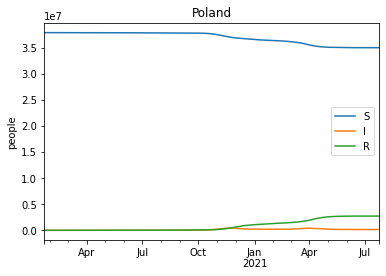

In [37]:
cc_idx = 9
country = list(cc_dict.values())[cc_idx]

S[country].plot()
I[country].plot()
R[country].plot()
plt.ylabel('people')
plt.title(country)
plt.legend(labels=['S', 'I', 'R'])
plt.show()

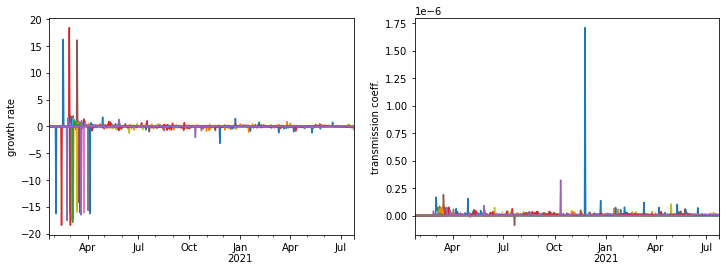

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
gr.plot(legend=False, ax=axs[0])
beta.plot(legend=False, ax=axs[1])
axs[0].set_ylabel('growth rate')
axs[1].set_ylabel('transmission coeff.')
plt.show()

Most countries present spikes at the beginning of the pandemic. Possibly due to reporting concentrations. Furthermore, low populated countries present various spikes.

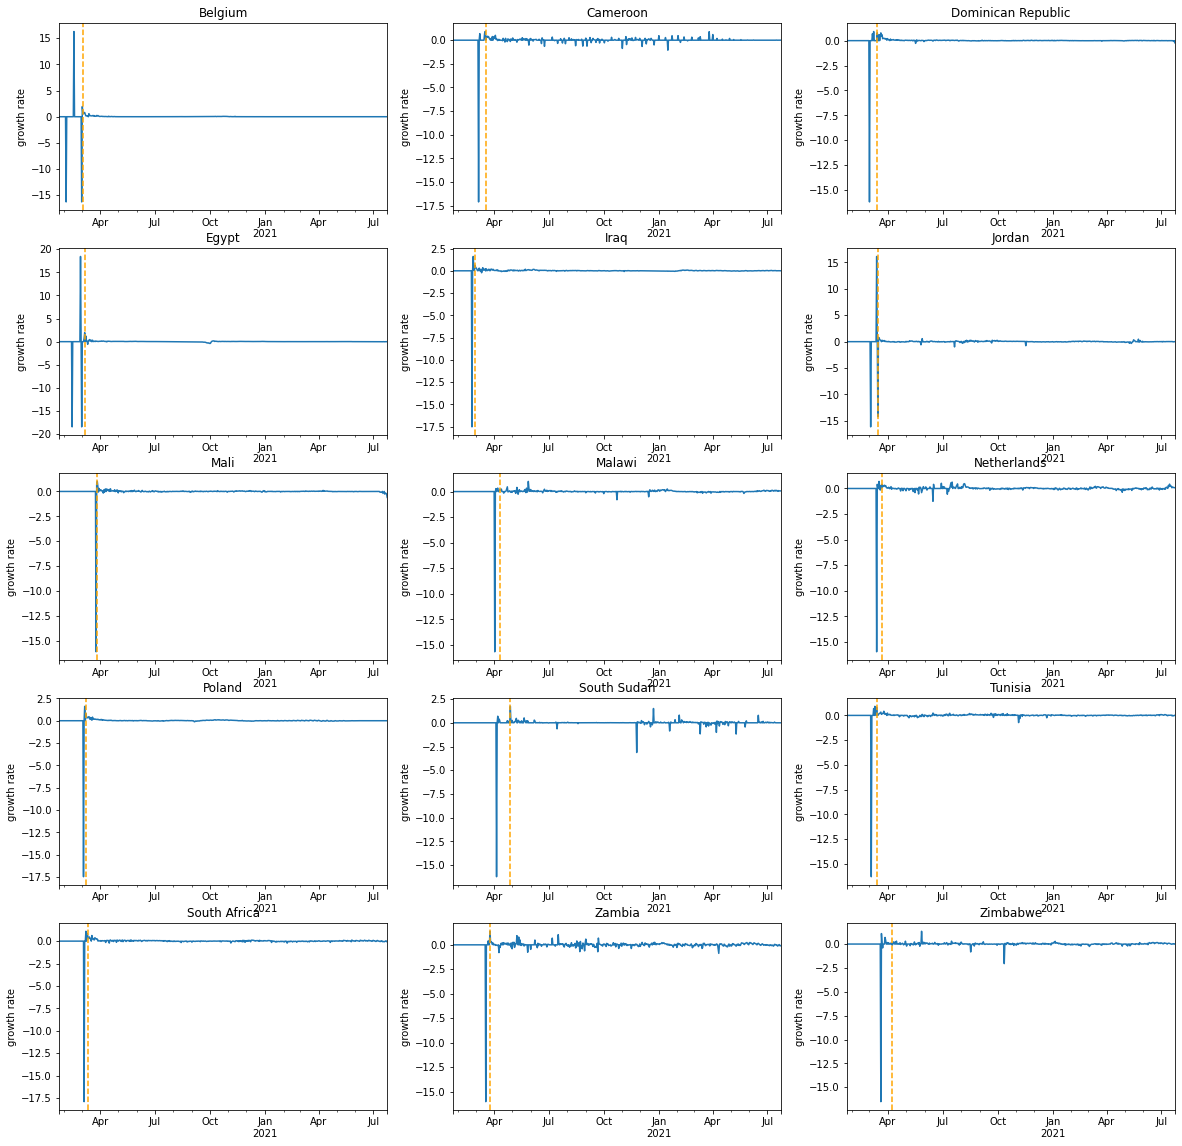

In [39]:
nrows = len(cc_dict) // 3
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
for i in range(nrows * ncols):
  cname = list(cc_dict.values())[i]
  first = cum_cases[cname][cum_cases[cname] > 10].index.min()
  ax = axs[i // ncols, i % ncols]
  gr[cname].plot(ax=ax)
  ax.axvline(first, ls='--', color='orange')
  ax.set_title(cname)
  ax.set_ylabel('growth rate')

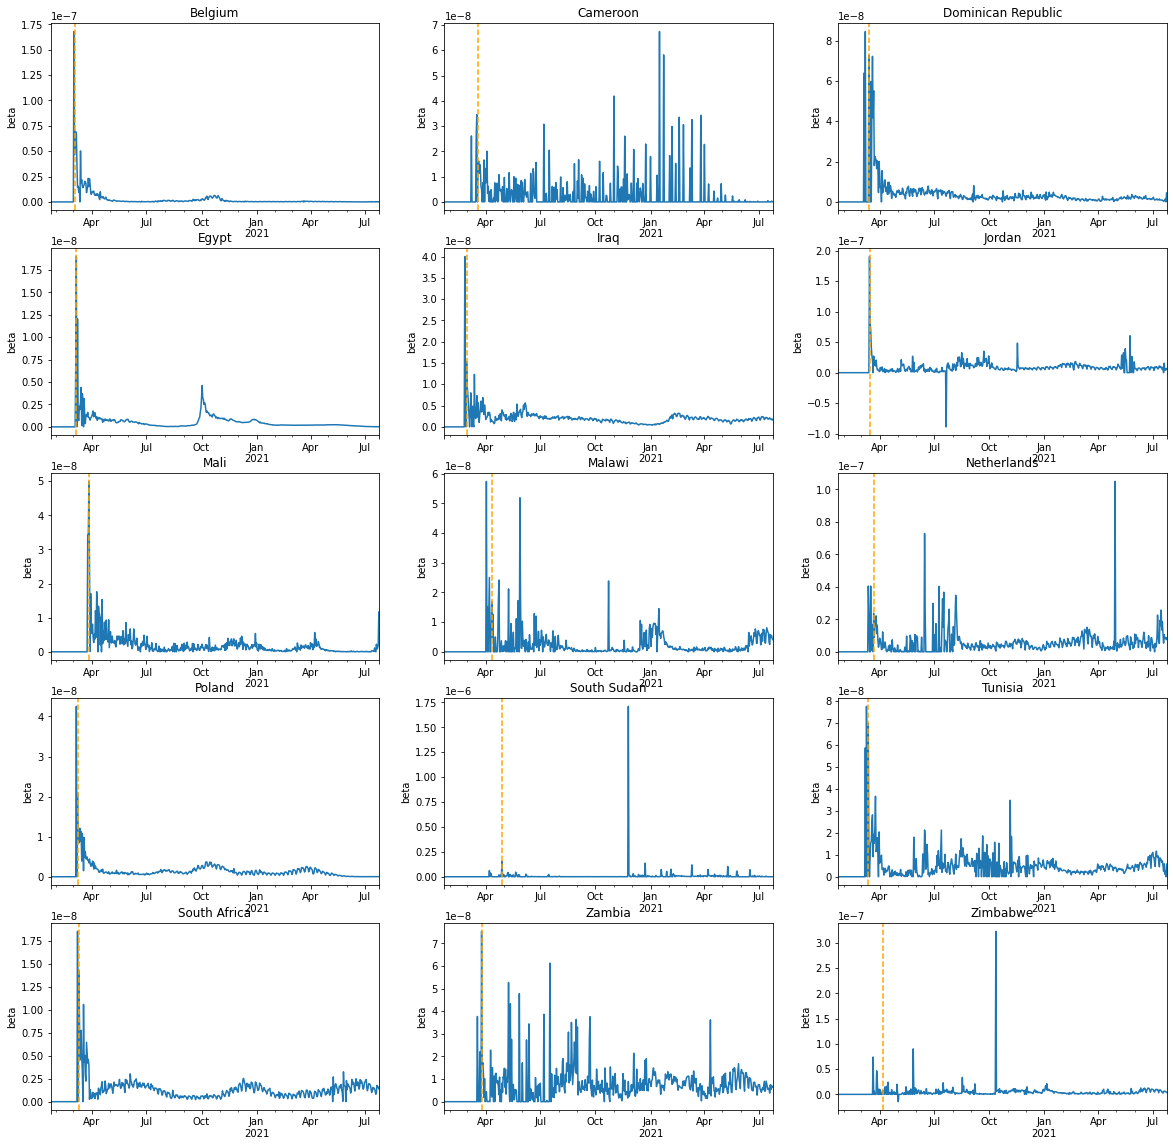

In [40]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
for i in range(nrows * ncols):
  cname = list(cc_dict.values())[i]
  first = cum_cases[cname].loc[cum_cases[cname] > 10].index.min()
  ax = axs[i // ncols, i % ncols]
  beta[cname].plot(ax=ax)
  ax.axvline(first, ls='--', color='orange')
  ax.set_title(cname)
  ax.set_ylabel('beta')

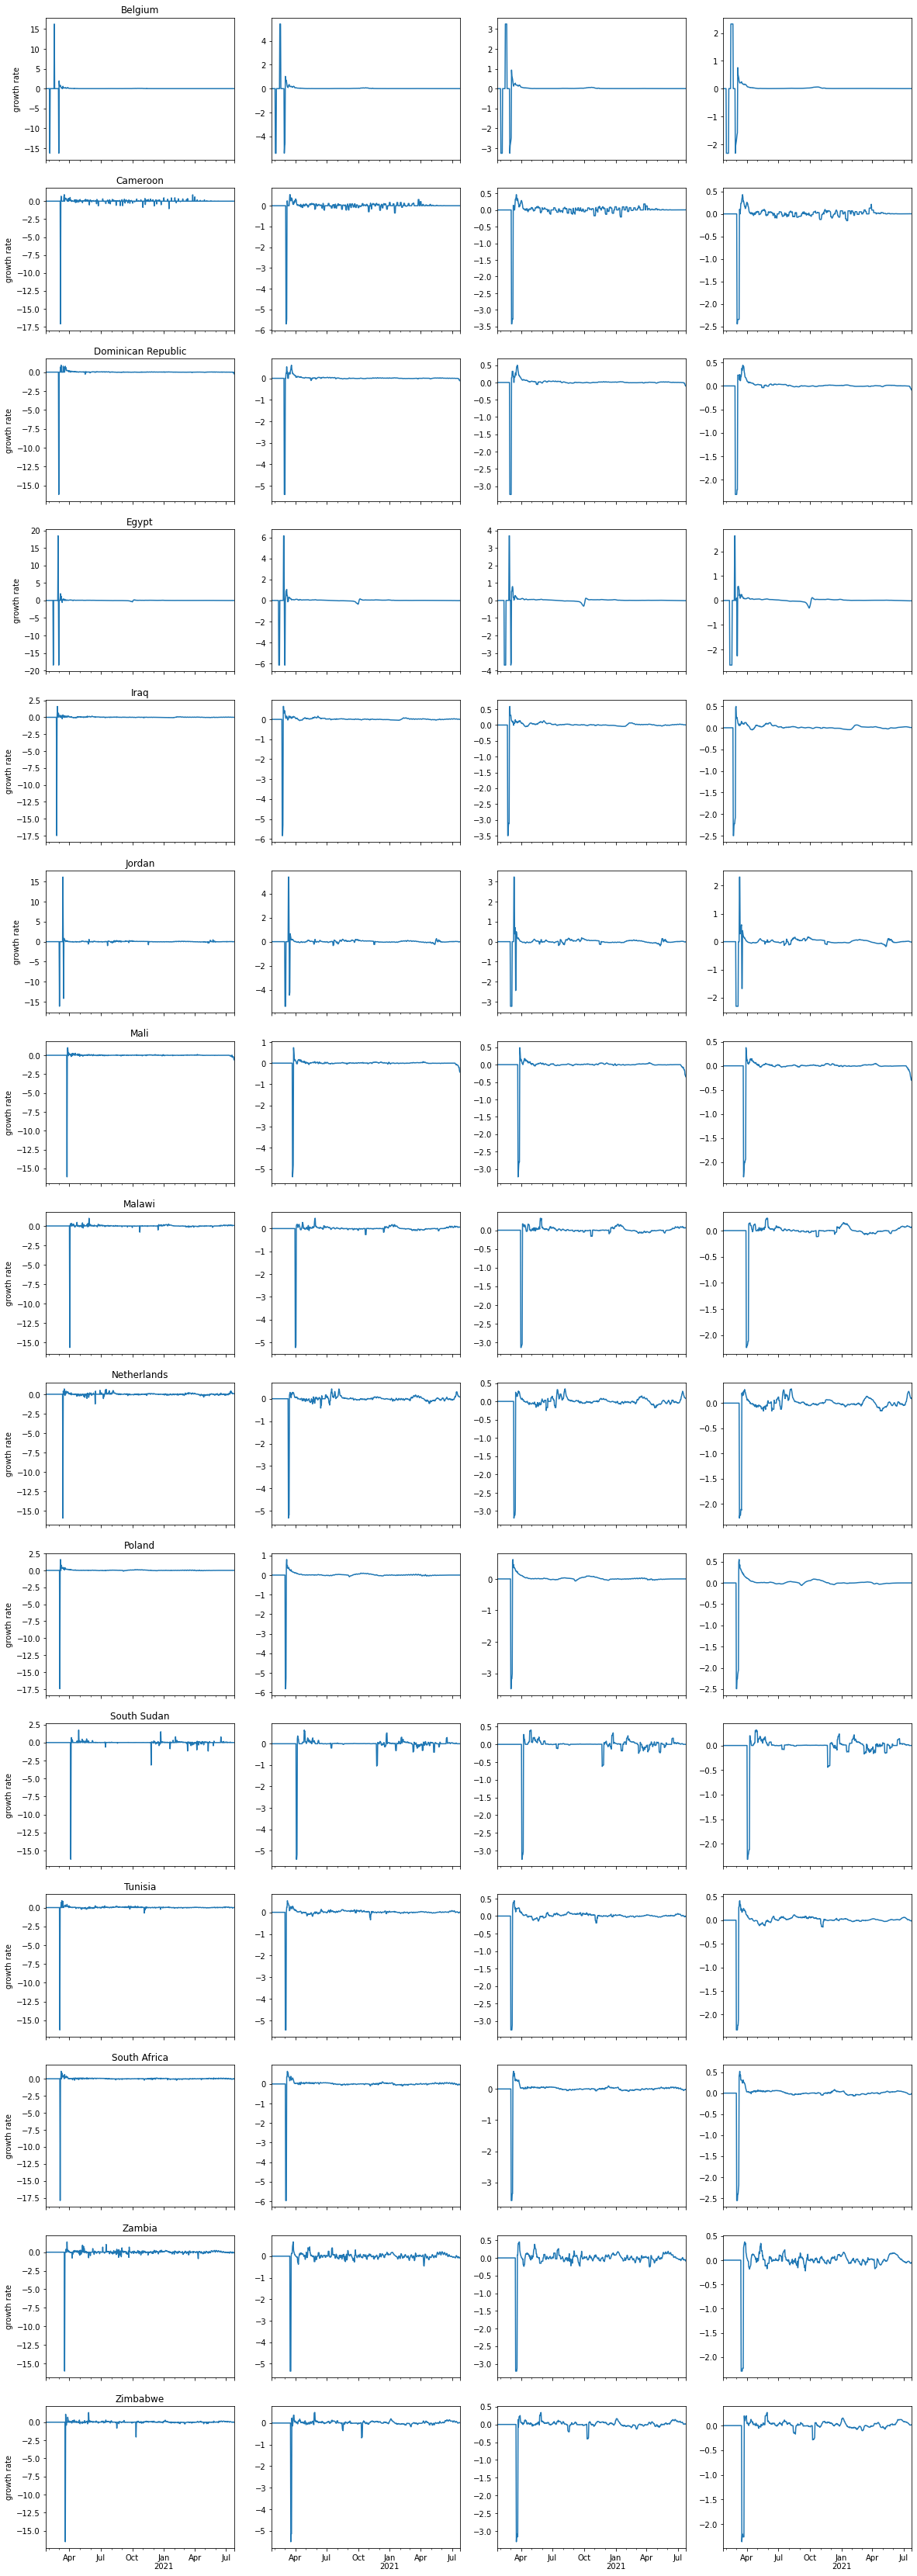

In [41]:
nrows = len(cc_dict)
ncols = 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(20, 60))
for i in range(nrows):
  cname = list(cc_dict.values())[i]
  gr[cname].plot(ax=axs[i, 0])
  gr[cname].rolling(3, min_periods=1, center=True).mean().plot(ax=axs[i, 1])
  gr[cname].rolling(5, min_periods=1, center=True).mean().plot(ax=axs[i, 2])
  gr[cname].rolling(7, min_periods=1, center=True).mean().plot(ax=axs[i, 3])
  axs[i, 0].set_title(cname)
  axs[i, 0].set_ylabel('growth rate')

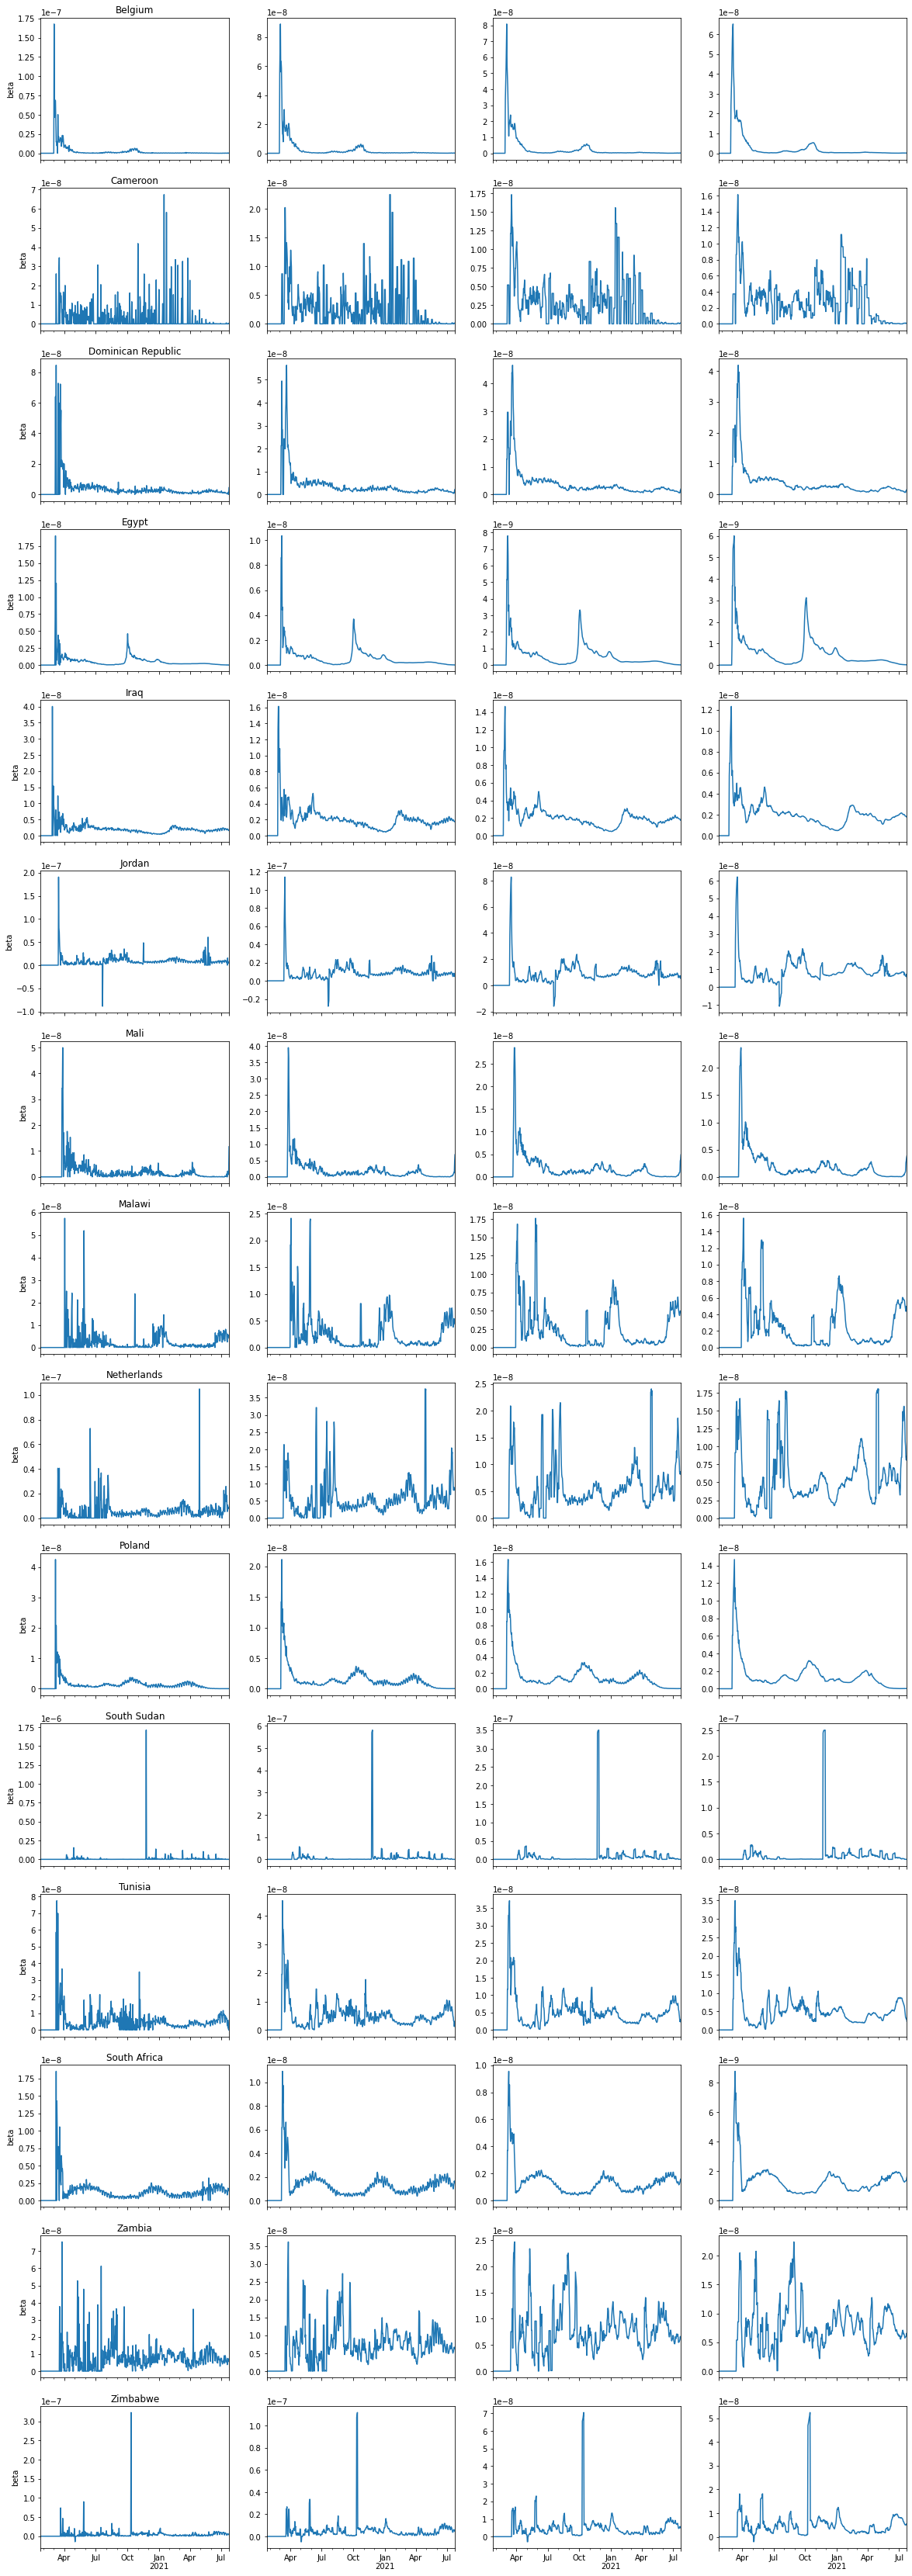

In [42]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(20, 60))
for i in range(nrows):
  cname = list(cc_dict.values())[i]
  beta[cname].plot(ax=axs[i, 0])
  beta[cname].rolling(3, min_periods=1, center=True).mean().plot(ax=axs[i, 1])
  beta[cname].rolling(5, min_periods=1, center=True).mean().plot(ax=axs[i, 2])
  beta[cname].rolling(7, min_periods=1, center=True).mean().plot(ax=axs[i, 3])
  axs[i, 0].set_title(cname)
  axs[i, 0].set_ylabel('beta')

# Model

Development of the model(s) and results.

## Auxiliar

In [43]:
# aux vars
ta = gr.index.min()
tb = gr.index.max()

chx_str = [s.split('_')[0] for s in idch]

In [44]:
ta == beta.index.min()

True

In [128]:
# aux fns
def data_from(iso, t0, tr, t_d, y):
  'Select data with location and time constraints.'

  if iso in cc_dict.keys():
    name = cc_dict[iso]
  else:
    raise NameError('Invalid ISO code.')
  
  if not t0:
    t0 = cum_cases.loc[cum_cases[name] > 25, name].index.min()
  if t0 < ta:
    t0 = ta # previous value NA otherwise
  prop_case = cum_cases[name] / pop_dict[iso]
  t1 = prop_case[prop_case < tr/100].index.max()
  
  delay = pd.to_timedelta(t_d, unit='days')
  ch_x = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_X]
  pol_t = pd.concat(ch_x, axis=1, ignore_index=True)
  
  y_t = y.loc[t0:t1, name]
  
  return pol_t, y_t

# to do: add day-of-the-week info
def preprocess(pol_t, y_t):
  'Transform data to feed the model.'
  
  pol_t.fillna(method='pad', inplace=True) # back fill
  pol_scaled = minmax_scale(pol_t[1:])     # match vars length at scaling

  # group data
  td1 = y_t[:-1].values.reshape(-1, 1)
  arr = np.hstack([pol_scaled, td1])
  col = np.append(chx_str, 'last')
  df = pd.DataFrame(arr, columns=col)
  
  return df.iloc[:, :-1], y_t[1:] # not using previous value

def _print_model(name, value, score):
  print('Coefficients\n------------')
  for n, v in zip(name, value):
    if v != 0:
      print('{:s} : {:3f}'.format(n, v))
  print('\nR^2\n---')
  print(round(score, 3))

## Initial model

Customized grid of values for the parameters. 

Using cross-validation on all available data, can yield sizeable negative values (sometimes) while performing least squares. Filter those values or assign value zero.

The code is:

```
cv_flag = True
y_df = gr_smooth
cv_arr = []
grid = {'tr': [0.5, 0.75, 1, 2, 3], 'delay': [7, 10, 14, 18, 21]}
lin = LinearRegression()
# lasso = LassoLarsCV(cv=KFold(shuffle=True), max_iter=3, eps=.1**7)
# lasso = LassoCV(cv=KFold(shuffle=True), max_iter=10**5)
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    cv_par = []
    X_raw, y_raw = data_from(cc, t0=None, tr=par['tr'], t_d=par['delay'], y=y_df)
    X, y = preprocess(X_raw, y_raw)
    if cv_flag:
      # cross-validation
      kf = KFold(shuffle=True)
      cv_kf = []
      for train_idx, test_idx in kf.split(X):
        fit = lin.fit(X.values[train_idx], y.values[train_idx])
        kf_score = fit.score(X.values[test_idx], y.values[test_idx])
        cv_kf.append(kf_score)
        score = np.asarray(cv_kf).mean()
    else:
      # train-test
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
      score = lin.fit(X_train, y_train).score(X_test, y_test)
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr
```

The LARS implementation of Lasso is much faster and it was used for the CV loop. However, the number of regressors needs to be restricted due to convergency issues and the general accuracy obtained is lower compared to the standard Lasso. Therefore, it is not used anymore.

In [129]:
y_df = gr_smooth
cv_arr = []
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [9, 12, 15, 18, 21]}
lin = LinearRegression()
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    X_raw, y_raw = data_from(cc, t0=None, tr=par['tr'], t_d=par['delay'], y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lin.fit(X.values[train_idx], y.values[train_idx])
      kf_score = fit.score(X.values[test_idx], y.values[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([-8.86491608e+24, -3.37990485e+23, -5.05000909e+25, -2.11246054e+24,
        6.43458547e-01, -2.95676869e+19, -1.82547059e+21, -1.11743458e+21,
       -1.37823257e+24,  6.62286979e-01,  2.97534617e-01, -2.23979224e+25,
        3.65356691e-01, -4.32424740e+19,  3.77467404e-01, -2.47024899e+24,
       -5.30330255e+24, -5.04134345e+23, -1.86338256e+19,  6.43978304e-01,
        5.35713740e-01, -7.64153027e+22, -2.84397570e+22, -8.02826038e+23,
        6.53147917e-01])

In [130]:
cv_arr.mean()

-3.7912005738109624e+24

In [131]:
y_df = gr_smooth
cv_arr = []
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [9, 12, 15, 18, 21]}
lasso = LassoCV(cv=KFold(shuffle=True), max_iter=10**5)
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    X_raw, y_raw = data_from(cc, t0=None, tr=par['tr'], t_d=par['delay'], y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lasso.fit(X.values[train_idx], y.values[train_idx])
      kf_score = fit.score(X.values[test_idx], y.values[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([0.57061757, 0.59767587, 0.60416493, 0.6506264 , 0.6274342 ,
       0.57194395, 0.6158445 , 0.622421  , 0.66485524, 0.65011289,
       0.518416  , 0.64957927, 0.65634291, 0.63651155, 0.64726125,
       0.48755863, 0.59566864, 0.61376978, 0.64788489, 0.62281448,
       0.45335015, 0.58063451, 0.63450415, 0.61568204, 0.61790734])

In [132]:
cv_arr.mean()

0.6061432850395889

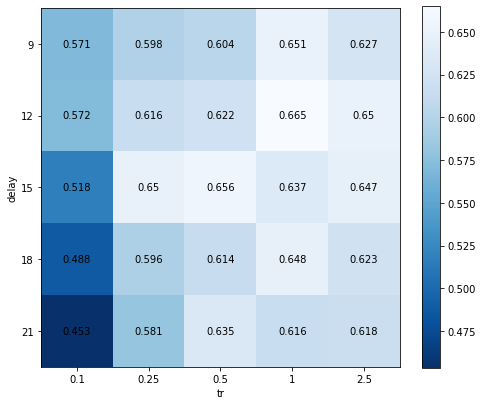

In [133]:
cv_mat = cv_arr.reshape(5, 5)
# heatmap
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(X=cv_mat, cmap='Blues_r') # 
# colorbar
ax.figure.colorbar(im, ax=ax, shrink=0.75)
# axis titles
ax.set_xlabel('tr')
ax.set_ylabel('delay')
# show all ticks...
ax.set_xticks(np.arange(len(grid['tr'])))
ax.set_yticks(np.arange(len(grid['delay'])))
# ...and label them
ax.set_xticklabels(grid['tr'])
ax.set_yticklabels(grid['delay'])
# loop over data dimensions and create text annotations
for i in range(len(grid['tr'])):
  for j in range(len(grid['delay'])):
    text = ax.text(j, i, round(cv_mat[i, j], ndigits=3), ha="center", va="center")
fig.tight_layout()
plt.show()

In [134]:
def initial_model(region, tr=1, delay=12, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - tr (float) : percentage (%) treshold for applying the approximation.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  X_raw, y_raw = data_from(region, None, tr, delay, gr_smooth)
  X, y = preprocess(X_raw, y_raw)
  coef_names = X.columns.values

  lasso = LassoCV(cv=KFold(shuffle=True), max_iter=10**4)
  reg = lasso.fit(X, y)
  score = reg.score(X, y)
  coef_values = reg.coef_

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y

Performance ($R^2$) for the chosen parameteres.

In [135]:
models = [initial_model(k) for k in cc_dict.keys()]
for reg, X, y in models:
  score = reg.score(X, y)
  print(round(score, 2))

0.97
0.67
0.97
0.81
0.9
0.29
0.92
0.84
0.86
0.99
0.65
0.9
0.94
0.75
0.76


In [152]:
idx = 5 # country index
cci = list(cc_dict.keys())[idx]
initial_model(cci, print=True)

Coefficients
------------
C2 : -0.009967
C7 : -0.003873
C8 : -0.090863
H6 : 0.017607

R^2
---
0.294


In [137]:
for i in idch:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls
H1 >> Public information campaigns
H6 >> Facial Coverings


Overfitting

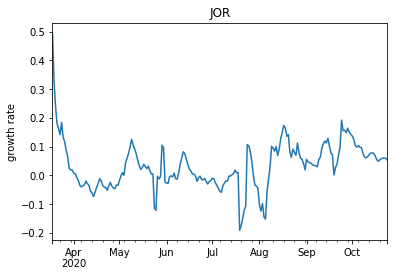

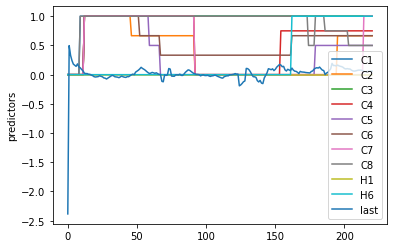


Number of data points: 221
Number of variables: 11


In [153]:
p_t, g_t = data_from(cci, None, 0.5, 12, gr_smooth)
p_t, g_t = preprocess(p_t, g_t)
# initial_model(cci)

g_t.plot()
plt.ylabel('growth rate')
plt.title(cci)
p_t.plot(legend=True)
plt.ylabel('predictors')
plt.show()

print('\nNumber of data points:', p_t.shape[0])
print('Number of variables:', p_t.shape[1])

Growth rate for every country of interest.

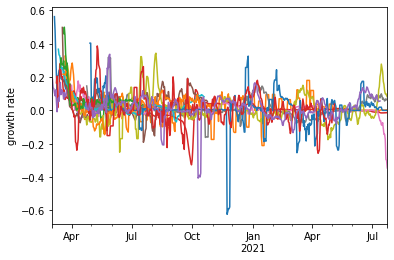

In [139]:
for cc in cc_dict:
  p_t, g_t = data_from(cc, t0=None, tr=0.5, t_d=18, y=gr_smooth)
  p_t, g_t = preprocess(p_t, g_t)
  g_t.plot()
plt.ylabel('growth rate')
plt.show()

## Transmission analysis

Parameter grid search.

In [140]:
y_df = beta_smooth
cv_arr = []
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [9, 12, 15, 18, 21]}
lin = LinearRegression()
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    X_raw, y_raw = data_from(cc, t0=None, tr=par['tr'], t_d=par['delay'], y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lin.fit(X.values[train_idx], y.values[train_idx])
      kf_score = fit.score(X.values[test_idx], y.values[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([-2.34385124e+22, -1.40710002e+21, -6.98054300e+23, -2.79594155e+18,
        7.85098129e-01, -4.71183608e+25, -5.83613155e+23, -1.67514239e+22,
       -2.47179695e+25,  4.47370069e-01, -2.37959540e-01, -9.29054674e+21,
       -9.18924075e+23, -3.68332026e+25,  7.94652089e-01,  5.73529088e-01,
       -4.76791659e+21, -3.66919720e+22, -1.16157047e+21,  7.88991353e-01,
        2.05505769e-01, -1.55732663e+23, -2.43833535e+23, -2.14620571e+17,
        8.20867939e-01])

In [141]:
cv_arr.mean()

-4.4545281035620905e+24

In [142]:
y_df = beta_smooth
cv_arr = []
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [9, 12, 15, 18, 21]}
lasso = LassoCV(cv=KFold(shuffle=True), max_iter=10**5)
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    X_raw, y_raw = data_from(cc, t0=None, tr=par['tr'], t_d=par['delay'], y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lasso.fit(X.values[train_idx], y.values[train_idx])
      kf_score = fit.score(X.values[test_idx], y.values[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([-0.21145356,  0.276036  ,  0.29115471,  0.31170019,  0.37819716,
        0.14128347,  0.24581035,  0.39399249,  0.38908727,  0.40359319,
        0.3386534 ,  0.27690451,  0.32324705,  0.37431665,  0.37396032,
       -0.89004055,  0.2000101 ,  0.28859055,  0.40559453,  0.38575902,
        0.21821537,  0.28534938,  0.33255728,  0.40274517,  0.41707893])

In [143]:
cv_arr.mean()

0.2540937196059359

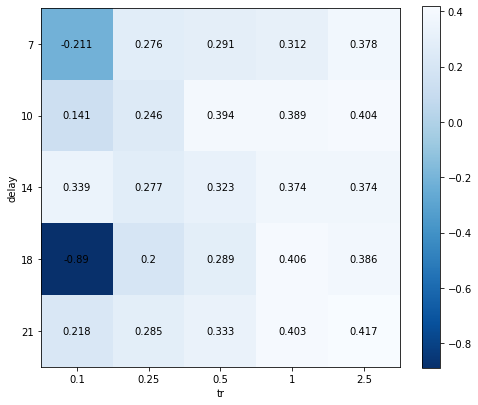

In [144]:
cv_mat = cv_arr.reshape(5, 5)
# heatmap
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(X=cv_mat, cmap='Blues_r')
# colorbar
ax.figure.colorbar(im, ax=ax, shrink=0.75)
# axis titles
ax.set_xlabel('tr')
ax.set_ylabel('delay')
# show all ticks...
ax.set_xticks(np.arange(len(grid['tr'])))
ax.set_yticks(np.arange(len(grid['delay'])))
# ...and label them
ax.set_xticklabels(grid['tr'])
ax.set_yticklabels(grid['delay'])
# loop over data dimensions and create text annotations
for i in range(len(grid['tr'])):
  for j in range(len(grid['delay'])):
    text = ax.text(j, i, round(cv_mat[i, j], ndigits=3), ha="center", va="center")
fig.tight_layout()
plt.show()

In [145]:
def linear_model(region, t0=None, tr=1, delay=12, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - t0 (str) : beginning of time frame.
  - tr (float) : percentage treshold for applying the approximation.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  X_raw, y_raw = data_from(region, t0, tr, delay, beta_smooth)
  X, y = preprocess(X_raw, y_raw)
  coef_names = X.columns.values

  lasso = LassoCV(cv=KFold(shuffle=True), max_iter=10**4)
  reg = lasso.fit(X, y)
  score = lasso.score(X, y)
  coef_values = reg.coef_

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y

In [146]:
# cv_arr = []
# grid = {'tr': [0.25, 0.5, 1, 2, 5], 'delay': [9, 12, 15, 18, 21]}
# lin = LinearRegression()
# for par in list(ParameterGrid(grid)):
#   cv_par = [linear_model(k, None, par['tr'], par['delay'])[3] for k in cc_dict.keys()]
#   cv_arr.append(cv_par)
# cv_arr = np.asarray(cv_arr).mean(axis=1) # country axis
# cv_arr

Performance ($R^2$) for the chosen parameteres.

In [147]:
models = [linear_model(k) for k in cc_dict.keys()]
for reg, X, y in models:
  score = reg.score(X, y)
  print(round(score, 2))

0.81
0.16
0.82
0.42
0.52
0.46
0.65
0.35
0.28
0.87
0.04
0.61
0.92
0.19
0.07


In [148]:
idx = 0 # country index
cci = list(cc_dict.keys())[idx]
linear_model(cci, print=True)

Coefficients
------------
C1 : -0.000000
C3 : -0.000000
C7 : 0.000000
C8 : -0.000000
H6 : -0.000000

R^2
---
0.807


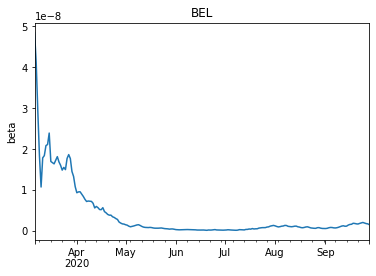

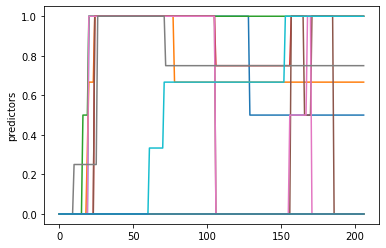


Number of data points: 207
Number of variables: 11


In [149]:
p_t, b_t = data_from(cci, None, 1, 12, beta_smooth)
p_t, b_t = preprocess(p_t, b_t)

b_t.plot()
plt.ylabel('beta')
plt.title(cci)
p_t.plot(legend=False)
plt.ylabel('predictors')
plt.show()

print('\nNumber of data points:', p_t.shape[0])
print('Number of variables:', p_t.shape[1])

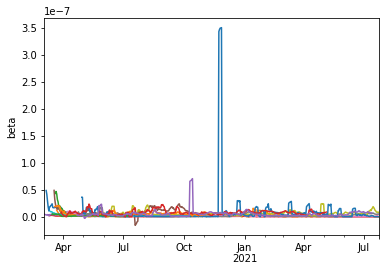

In [150]:
for cc in cc_dict:
  p_t, b_t = data_from(cc, t0=None, tr=0.5, t_d=18, y=beta_smooth)
  p_t, b_t = preprocess(p_t, b_t)
  b_t.plot()
plt.ylabel('beta')
plt.show()